## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [1]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary  # install with 'pip install torchsummary'
from tensorboardX import SummaryWriter

%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
def plot_images(X, labels):
    num_plots = X.shape[0]
    w_min, w_max = np.min(X), np.max(X)
        
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    for i in range(num_plots):
        plt.subplot(3, 3, i + 1)

        # Rescale the weights to be between 0 and 255
        img = 255.0 * (X[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        plt.title(classes[labels[i].item()])

Files already downloaded and verified
Files already downloaded and verified


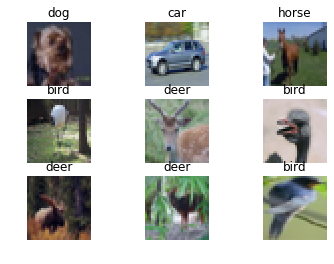

In [3]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader()

In [4]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=12, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=6, kernel_size=3, padding=1)   
        self.fc1 = nn.Linear(in_features=(6*8*8), out_features=96)
        self.fc2 = nn.Linear(in_features=96, out_features=n_output)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 6*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [5]:
# init net
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = ConvNet().to(device)

# plot net parameters
summary(net, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             912
         MaxPool2d-2           [-1, 12, 16, 16]               0
            Conv2d-3            [-1, 6, 16, 16]             654
         MaxPool2d-4              [-1, 6, 8, 8]               0
            Linear-5                   [-1, 96]          36,960
            Linear-6                   [-1, 10]             970
Total params: 39,496
Trainable params: 39,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.13
Params size (MB): 0.15
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


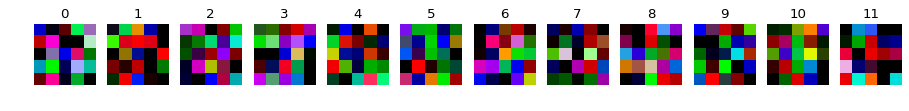

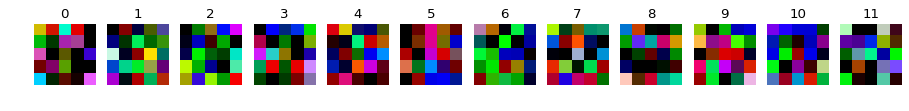

In [6]:
# visualize weights
def plot_weights(w, scaling=False):
    if w.shape[1] != 3:
        print('Cannot visualize filter with this dimensions: {}!'.format(w[0,:,:,:].shape))
        
    else:
        num_plots = w.shape[0]
        
        # plot positive weight entries
        plt.figure(num=None, figsize=(14, 6), dpi=80)
        for i in range(num_plots):
            plt.subplot(1, num_plots, i + 1)

            # Rescale the weights to be between 0 and 255
            img = w[i, :, :, :].squeeze().clip(0,1)
            if scaling:
                img -= np.min(img)
                img /= np.max(img)
            img *= 255.
            plt.imshow(img.transpose().astype('uint8'))
            plt.axis('off')
            plt.title(str(i))
        plt.show()

        # plot negative weight entries
        plt.figure(num=None, figsize=(14, 6), dpi=80)
        for i in range(num_plots):
            plt.subplot(1, num_plots, i + 1)

            # Rescale the weights to be between 0 and 255
            img = w[i, :, :, :].squeeze().clip(-1,0) * (-1)
            if scaling:
                img -= np.min(img)
                img /= np.max(img)
            img *= 255.
            plt.imshow(img.transpose().astype('uint8'))
            plt.axis('off')
            plt.title(str(i))
        plt.show()
    

w = net.conv1.weight.data.numpy()
plot_weights(w,scaling=True)
#fig.show()

In [7]:
# check output for dummy input
input_dummy = torch.empty(1,3,32,32).normal_(0, 0.01)
output_dummy = net(input_dummy)
print(output_dummy)

tensor([[-0.0604,  0.1088, -0.0426,  0.0598, -0.0175,  0.0059, -0.0387,  0.0977,
         -0.0787, -0.0819]], grad_fn=<AddmmBackward>)



--- EPOCH 001 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600


/home/simon/.virtualenvs/epfl_dlav_py3/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Metrics: 
---> train loss / accuracy: 1.400 / 0.50
---> val loss / accuracy:   1.457 / 0.49
filters conv1


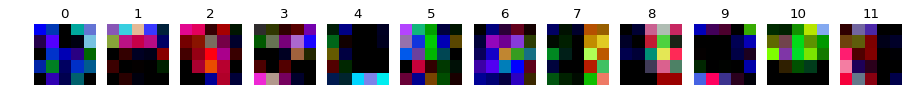

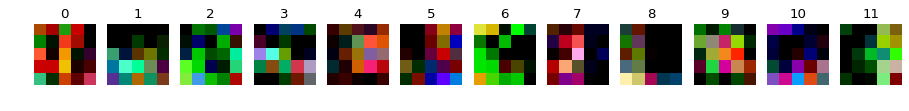


--- EPOCH 002 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.284 / 0.54
---> val loss / accuracy:   1.349 / 0.52
filters conv1


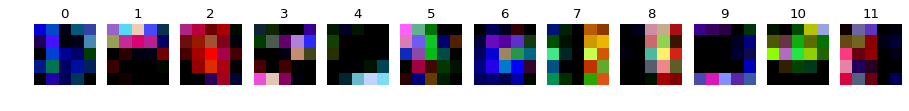

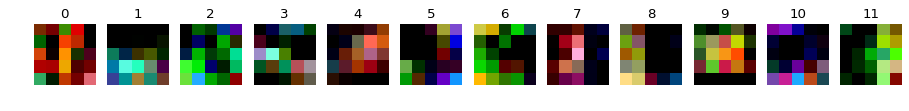


--- EPOCH 003 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.199 / 0.58
---> val loss / accuracy:   1.277 / 0.54
filters conv1


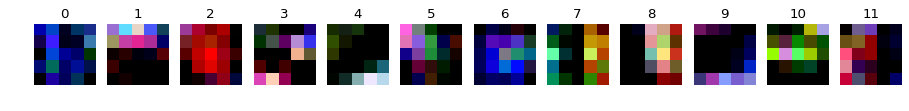

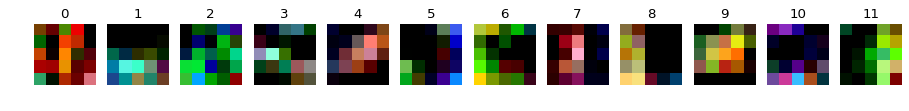


--- EPOCH 004 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.185 / 0.58
---> val loss / accuracy:   1.268 / 0.56
filters conv1


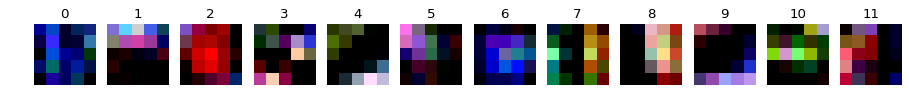

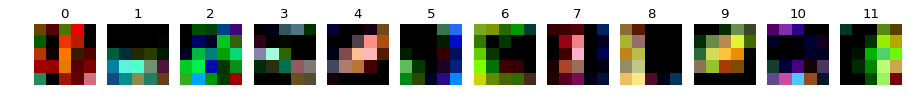


--- EPOCH 005 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.149 / 0.60
---> val loss / accuracy:   1.230 / 0.58
filters conv1


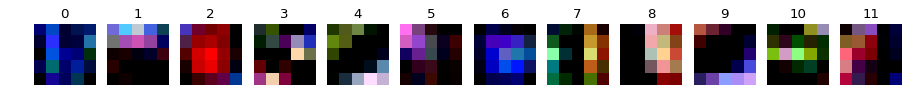

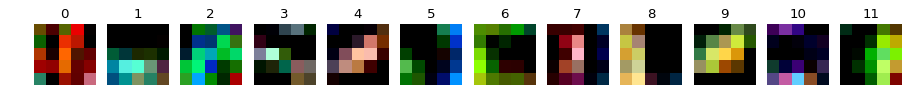


--- EPOCH 006 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.134 / 0.60
---> val loss / accuracy:   1.215 / 0.58
filters conv1


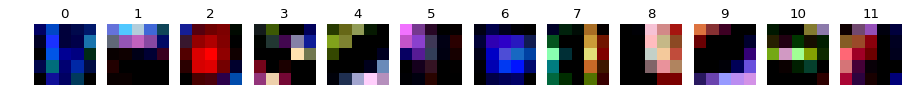

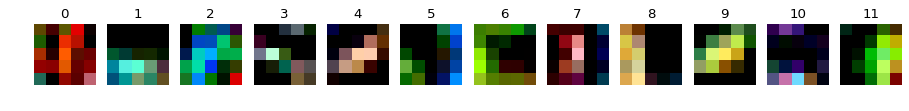


--- EPOCH 007 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.122 / 0.60
---> val loss / accuracy:   1.228 / 0.58
filters conv1


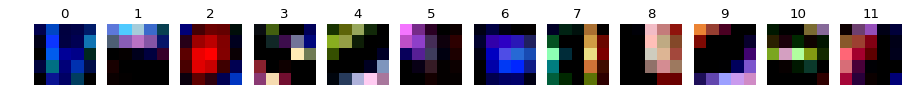

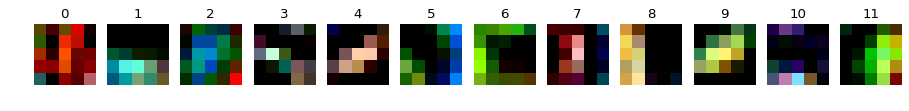


--- EPOCH 008 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.056 / 0.63
---> val loss / accuracy:   1.147 / 0.59
filters conv1


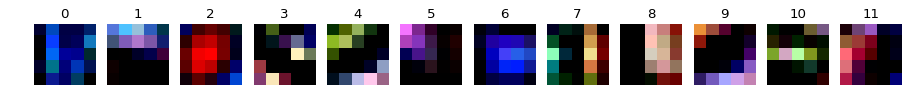

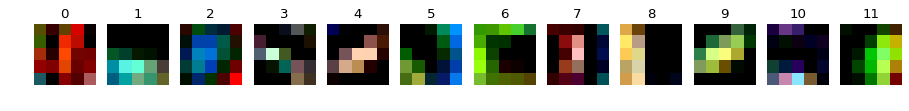


--- EPOCH 009 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.052 / 0.63
---> val loss / accuracy:   1.177 / 0.57
filters conv1


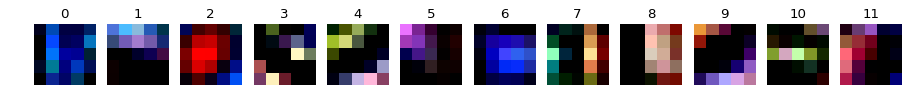

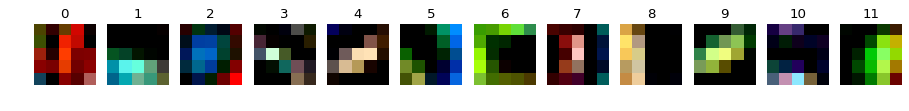


--- EPOCH 010 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.009 / 0.65
---> val loss / accuracy:   1.087 / 0.61
filters conv1


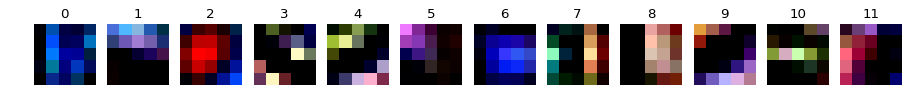

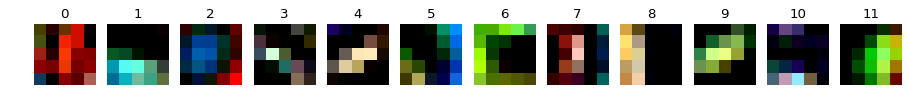


--- EPOCH 011 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.044 / 0.63
---> val loss / accuracy:   1.158 / 0.59
filters conv1


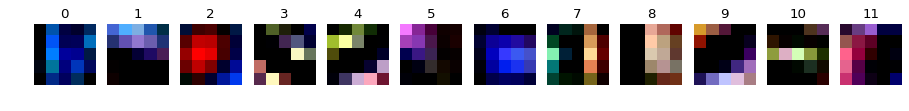

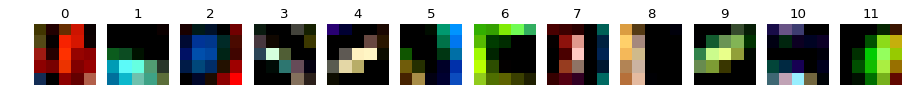


--- EPOCH 012 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.001 / 0.65
---> val loss / accuracy:   1.084 / 0.62
filters conv1


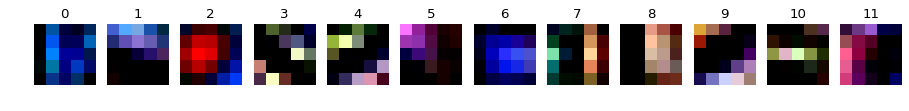

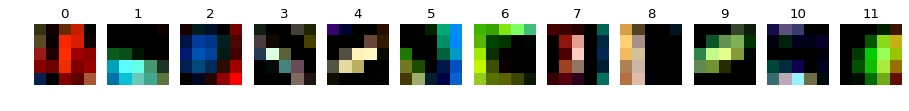


--- EPOCH 013 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.979 / 0.65
---> val loss / accuracy:   1.083 / 0.61
filters conv1


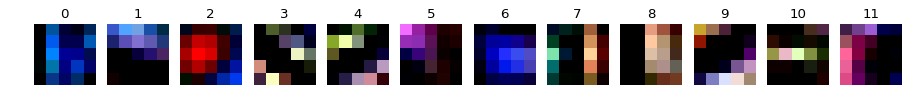

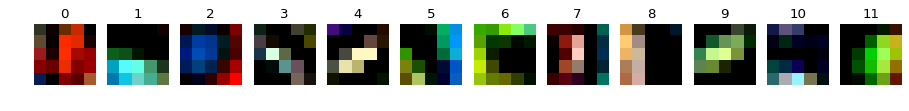


--- EPOCH 014 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.970 / 0.66
---> val loss / accuracy:   1.064 / 0.63
filters conv1


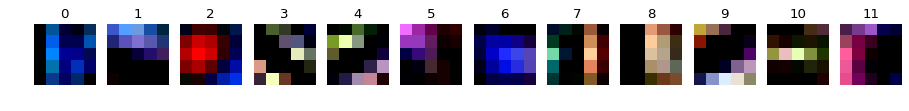

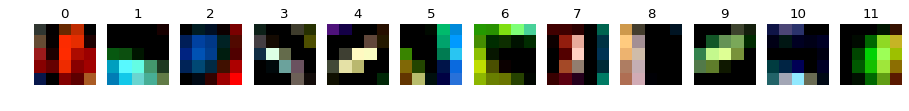


--- EPOCH 015 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.973 / 0.66
---> val loss / accuracy:   1.046 / 0.62
filters conv1


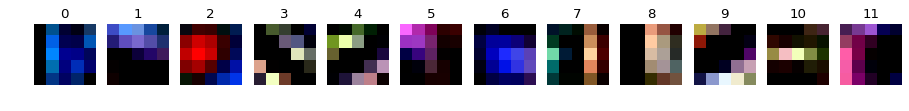

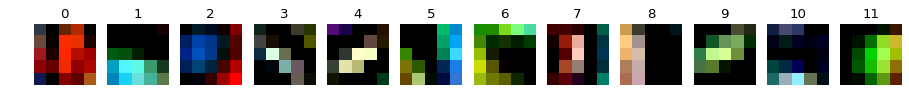


--- EPOCH 016 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.977 / 0.66
---> val loss / accuracy:   1.065 / 0.64
filters conv1


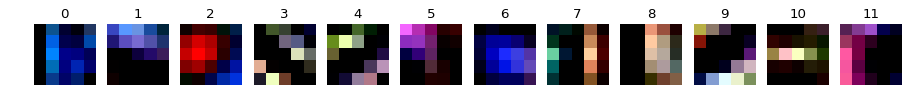

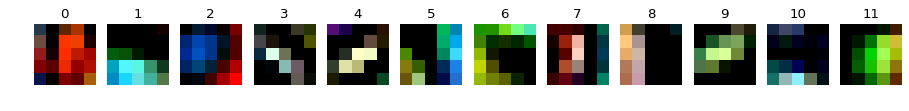


--- EPOCH 017 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.918 / 0.68
---> val loss / accuracy:   1.020 / 0.64
filters conv1


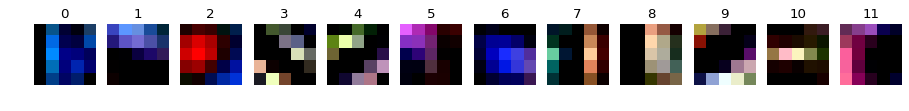

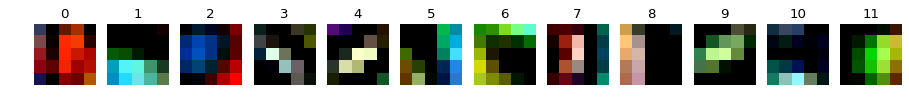


--- EPOCH 018 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.935 / 0.68
---> val loss / accuracy:   1.028 / 0.63
filters conv1


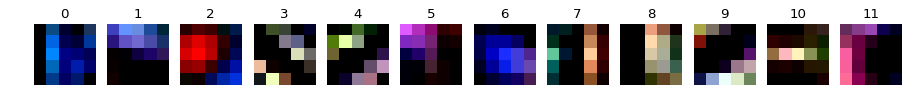

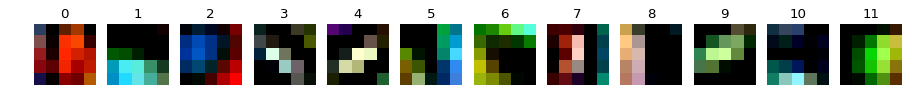


--- EPOCH 019 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.938 / 0.67
---> val loss / accuracy:   1.057 / 0.62
filters conv1


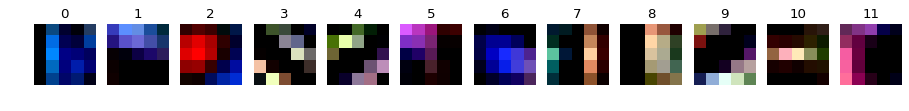

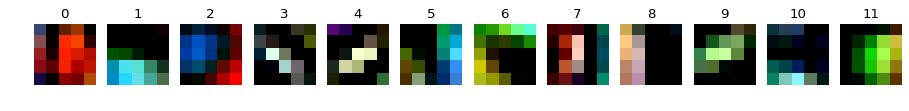


--- EPOCH 020 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.954 / 0.67
---> val loss / accuracy:   1.051 / 0.62
filters conv1


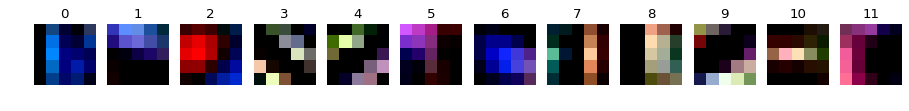

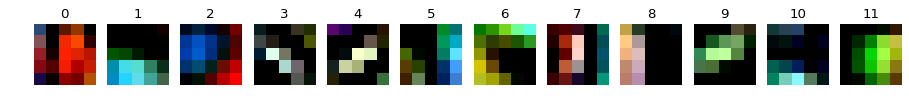


--- EPOCH 021 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.931 / 0.67
---> val loss / accuracy:   1.019 / 0.63
filters conv1


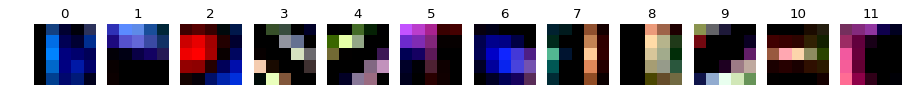

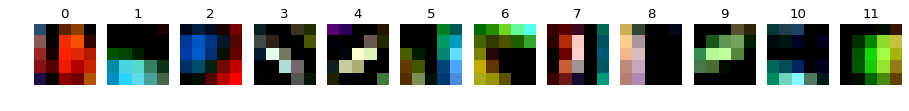


--- EPOCH 022 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.924 / 0.68
---> val loss / accuracy:   1.035 / 0.65
filters conv1


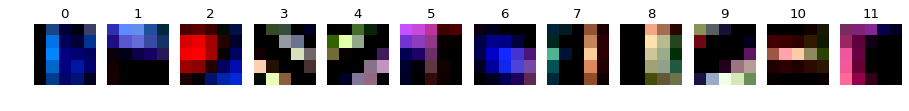

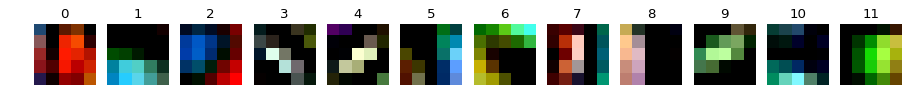


--- EPOCH 023 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.924 / 0.68
---> val loss / accuracy:   1.023 / 0.65
filters conv1


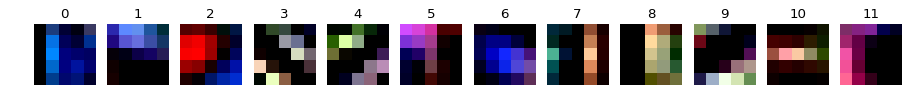

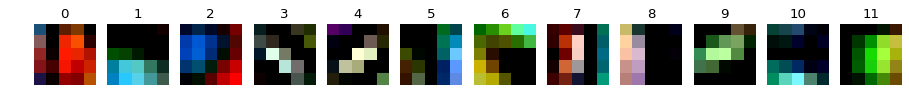


--- EPOCH 024 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.903 / 0.69
---> val loss / accuracy:   0.989 / 0.65
filters conv1


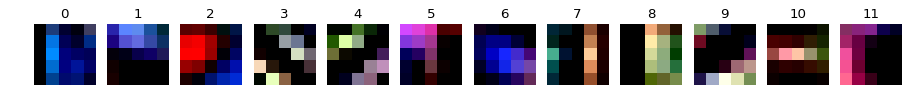

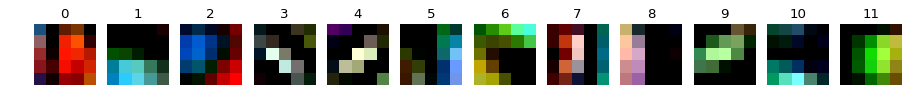


--- EPOCH 025 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.905 / 0.69
---> val loss / accuracy:   1.015 / 0.65
filters conv1


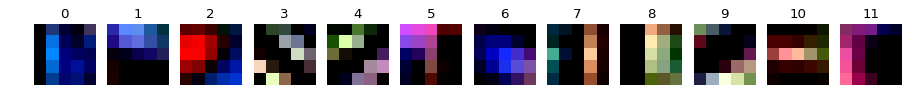

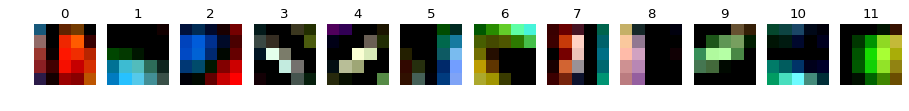


--- EPOCH 026 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.929 / 0.67
---> val loss / accuracy:   1.034 / 0.64
filters conv1


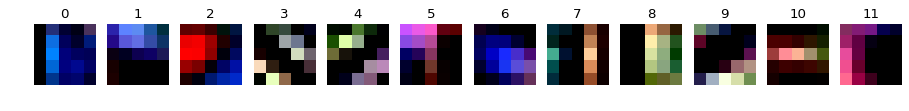

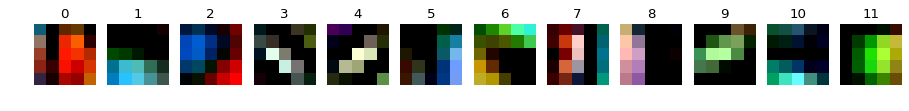


--- EPOCH 027 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.916 / 0.68
---> val loss / accuracy:   1.014 / 0.64
filters conv1


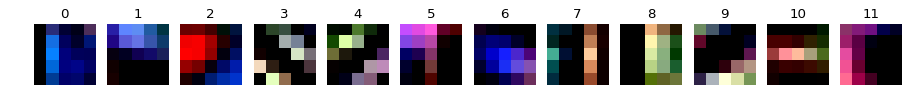

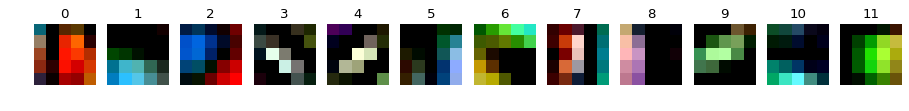


--- EPOCH 028 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.915 / 0.68
---> val loss / accuracy:   1.013 / 0.65
filters conv1


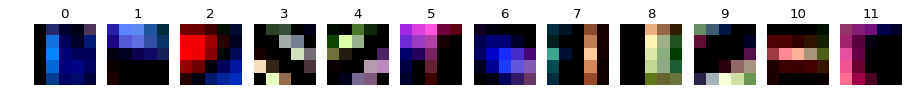

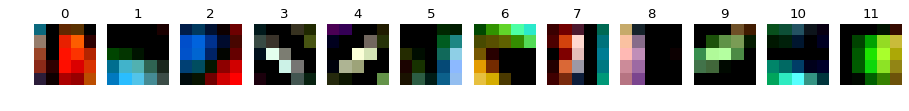


--- EPOCH 029 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.906 / 0.68
---> val loss / accuracy:   1.003 / 0.63
filters conv1


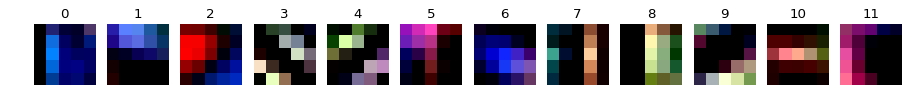

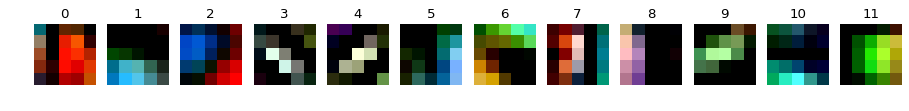


--- EPOCH 030 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.924 / 0.68
---> val loss / accuracy:   1.037 / 0.63
filters conv1


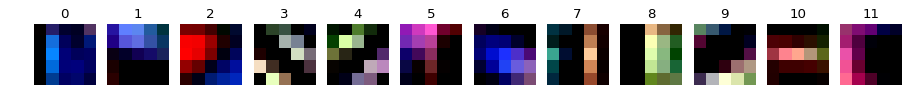

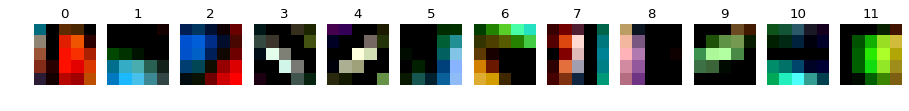

In [8]:
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
learning_rate = 1e-3
decayRate = 0.1
l2_reg = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=l2_reg)

# https://discuss.pytorch.org/t/how-to-do-exponential-learning-rate-decay-in-pytorch/63146/3
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=decayRate, patience=5)


epochs = 30
running_loss = 0
print_every = 200
training_steps = 0

# init tensorboard writer
writer = SummaryWriter()

for e in range(epochs):
    
    print('\n--- EPOCH %03d / %03d STARTED ---' % (e+1, epochs))
 
    # set net to train mode
    net.train()
    
    # log current learning rate
    writer.add_scalar('optimizer/learning_rate', optimizer.param_groups[0]['lr'], e+1)
    
    # train over all batches
    start = time.time()
    for idx_batch, (images, labels) in enumerate(trainloader):
        
        training_steps += 1
        
        if idx_batch % print_every == 0:
            print('---> train on batch %03d' % idx_batch)
        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('train/loss_training_step', loss.item(), training_steps)
        
    # set net to evaluation mode
    net.eval()
    
    # evaluate on training data 
    train_loss_accum = 0.
    count_total = 0
    count_correct = 0
    for idx_batch, (images, labels) in enumerate(trainloader):
        output = net(images)
        loss = criterion(output, labels)
        train_loss_accum += loss.item()
        
        prediction = torch.argmax(net.predict(images), axis=1)
        count_total += prediction.size(0)
        count_correct += (prediction == labels).sum().item()
        
    train_loss_avg = train_loss_accum / (idx_batch+1)
    train_acc = count_correct / count_total
    writer.add_scalar('train/loss_epoch', train_loss_avg, e+1)
    writer.add_scalar('train/accuracy', train_acc, e+1)
    
    # evaluate on validation data 
    val_loss_accum = 0.
    count_total = 0
    count_correct = 0
    for idx_batch, (images, labels) in enumerate(valloader):
        output = net(images)
        loss = criterion(output, labels)
        val_loss_accum += loss.item()
        
        prediction = torch.argmax(net.predict(images), axis=1)
        count_total += prediction.size(0)
        count_correct += (prediction == labels).sum().item()

    val_loss_avg = val_loss_accum / (idx_batch+1)
    val_acc = count_correct / count_total
    writer.add_scalar('val/loss_epoch', val_loss_avg, e+1)
    writer.add_scalar('val/accuracy', val_acc, e+1)
    
    print('\nMetrics: ')
    print('---> train loss / accuracy: %.03f / %.02f' % (train_loss_avg, train_acc))
    print('---> val loss / accuracy:   %.03f / %.02f' % (val_loss_avg, val_acc))
    
    scheduler.step(val_loss_avg)
    
    print('filters conv1')
    w1 = net.conv1.weight.data.numpy()
    plot_weights(w1, scaling=True)
    

# close tensorboard logging
writer.close()

Save best trained model.

In [9]:
torch.save(net.state_dict(), 'model_%.02f.ckpt' % val_acc)